In [1]:
%load_ext autoreload
%autoreload 2
%env WANDB_NOTEBOOK_NAME analysis.ipynb
%env WANDB_SILENT true

from collections import defaultdict
import os
import time

import inept
from IPython import display
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import torch
import wandb

# Set params
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
BASE_FOLDER = os.path.abspath('')
DATA_FOLDER = os.path.join(BASE_FOLDER, '../data')
PLOT_FOLDER = os.path.join(BASE_FOLDER, '../plots')
TEMP_FOLDER = os.path.join(BASE_FOLDER, 'temp')

# Disable gradients
torch.set_grad_enabled(False)

# Style
sns.set_context('paper', font_scale=1.25)
sns.set_style('white')
sns.set_palette('Accent')
PALETTE = 'husl'

env: WANDB_NOTEBOOK_NAME=analysis.ipynb
env: WANDB_SILENT=true


- HIGH PRIORITY
  - First frame is slightly different
  - Continual perturbation analysis

### Parameters

In [2]:
# Animation parameters
# Any - 500 - 500
# 2000 - 50 - None
# 1000 - 200 - None
# 500 - None - None
generalize = True
num_nodes_max = 2_000
MAX_BATCH = 50
MAX_NODES = None
run_id = 'v8q9fmme'  # BC: g8ex944e, scG: v8q9fmme

### Load Files

In [3]:
# Load run from the wandb API
api = wandb.Api()
run = api.run(f'oafish/uncategorized/{run_id}')

# Load configs
config = defaultdict(lambda: {})
for k, v in run.config.items():
    dict_name, key = k.split('/')
    config[dict_name][key] = v
config = dict(config)

# Load model
fname = f'trained_models/policy_{run.summary["stage"]:02}.mdl'
run.file(fname).download(TEMP_FOLDER, replace=True)
policy = torch.load(os.path.join(TEMP_FOLDER, fname)).to(DEVICE).eval()
policy.actor.set_action_std(1e-7)  # Place in execution mode (TODO: 0)

In [4]:
# Reproducibility
torch.manual_seed(config['note']['seed'])
if DEVICE == 'cuda': torch.cuda.manual_seed(config['note']['seed'])
np.random.seed(config['note']['seed'])

In [5]:
# Load data
dataset_name = config['data']['dataset']

if dataset_name == 'scNMT':
    dataset_dir = os.path.join(DATA_FOLDER, 'UnionCom/scNMT')
    M1 = pd.read_csv(os.path.join(dataset_dir, 'Paccessibility_300.txt'), delimiter=' ', header=None).to_numpy()
    M2 = pd.read_csv(os.path.join(dataset_dir, 'Pmethylation_300.txt'), delimiter=' ', header=None).to_numpy()
    M3 = pd.read_csv(os.path.join(dataset_dir, 'RNA_300.txt'), delimiter=' ', header=None).to_numpy()
    T1 = pd.read_csv(os.path.join(dataset_dir, 'type1.txt'), delimiter=' ', header=None).to_numpy().flatten()
    T2 = pd.read_csv(os.path.join(dataset_dir, 'type2.txt'), delimiter=' ', header=None).to_numpy().flatten()
    T3 = pd.read_csv(os.path.join(dataset_dir, 'type3.txt'), delimiter=' ', header=None).to_numpy().flatten()

    modalities = [M1, M2, M3][1]
    types = [T1, T2, T3][1]
    features = [[i for i in range(M.shape[1])] for M in modalities]

elif dataset_name == 'BrainChromatin':
    nrows = None  # 2_000
    dataset_dir = os.path.join(DATA_FOLDER, 'brainchromatin')
    M1 = pd.read_csv(os.path.join(dataset_dir, 'multiome_rna_counts.tsv'), delimiter='\t', nrows=nrows).transpose()  # 4.6 Gb in memory
    M2 = pd.read_csv(os.path.join(dataset_dir, 'multiome_atac_gene_activities.tsv'), delimiter='\t', nrows=nrows).transpose()  # 2.6 Gb in memory
    M2 = M2.transpose()[M1.index].transpose()
    meta = pd.read_csv(os.path.join(dataset_dir, 'multiome_cell_metadata.txt'), delimiter='\t')
    meta_names = pd.read_csv(os.path.join(dataset_dir, 'multiome_cluster_names.txt'), delimiter='\t')
    meta_names = meta_names[meta_names['Assay'] == 'Multiome ATAC']
    meta = pd.merge(meta, meta_names, left_on='ATAC_cluster', right_on='Cluster.ID', how='left')
    meta.index = meta['Cell.ID']
    T1 = T2 = np.array(meta.transpose()[M1.index].transpose()['Cluster.Name'])
    F1, F2 = M1.columns, M2.columns
    M1, M2 = M1.to_numpy(), M2.to_numpy()

    modalities = [M1, M2]
    types = [T1, T2]
    features = [F1, F2]

    del meta, meta_names

elif dataset_name == 'scGLUE':
    import scanpy as sc
    dataset_dir = os.path.join(DATA_FOLDER, 'scglue')
    D1 = sc.read_h5ad(os.path.join(dataset_dir, 'Chen-2019-RNA.h5ad'))
    D2 = sc.read_h5ad(os.path.join(dataset_dir, 'Chen-2019-ATAC.h5ad'))
    M1 = np.asarray(D1.X.todense())
    M2 = np.asarray(D2.X.todense())
    T1 = D1.obs.cell_type.to_numpy()
    T2 = D2.obs.cell_type.to_numpy()
    F1 = D1.var.index.to_numpy()
    F2 = D2.var.index.to_numpy()

    modalities = [M1, M2]
    types = [T1, T2]
    features = [F1, F2]

    del D1, D2

elif dataset_name == 'scGEM':
    dataset_dir = os.path.join(DATA_FOLDER, 'UnionCom/scGEM')
    M1 = pd.read_csv(os.path.join(dataset_dir, 'GeneExpression.txt'), delimiter=' ', header=None).to_numpy()
    M2 = pd.read_csv(os.path.join(dataset_dir, 'DNAmethylation.txt'), delimiter=' ', header=None).to_numpy()
    T1 = pd.read_csv(os.path.join(dataset_dir, 'type1.txt'), delimiter=' ', header=None).to_numpy()
    T2 = pd.read_csv(os.path.join(dataset_dir, 'type2.txt'), delimiter=' ', header=None).to_numpy()
    F1 = np.loadtxt(os.path.join(dataset_dir, 'gex_names.txt'), dtype='str')
    F2 = np.loadtxt(os.path.join(dataset_dir, 'dm_names.txt'), dtype='str')

    modalities = [M1, M2]
    types = [T1, T2]
    features = [F1, F2]

# MMD-MA data
elif dataset_name == 'MMD-MA':
    dataset_dir = os.path.join(DATA_FOLDER, 'UnionCom/MMD')
    M1 = pd.read_csv(os.path.join(dataset_dir, 's1_mapped1.txt'), delimiter='\t', header=None).to_numpy()
    M2 = pd.read_csv(os.path.join(dataset_dir, 's1_mapped2.txt'), delimiter='\t', header=None).to_numpy()
    T1 = pd.read_csv(os.path.join(dataset_dir, 's1_type1.txt'), delimiter='\t', header=None).to_numpy()
    T2 = pd.read_csv(os.path.join(dataset_dir, 's1_type2.txt'), delimiter='\t', header=None).to_numpy()

    modalities = [M1, M2]
    types = [T1, T2]
    features = [[i for i in range(M.shape[1])] for M in modalities]

# Random data
elif dataset_name == 'Random':
    num_nodes = 100
    M1 = torch.rand((num_nodes, 8), device=DEVICE)
    M2 = torch.rand((num_nodes, 16), device=DEVICE)

    modalities = [M1, M2]
    types = [2*[0 for _ in range(num_nodes)]]
    features = [[i for i in range(M.shape[1])] for M in modalities]

else: assert False, 'No matching dataset found.'

# Parameters
num_nodes = M1.shape[0] if generalize else config['data']['num_nodes']  # TODO OMG
if num_nodes_max is not None: num_nodes = min(num_nodes, num_nodes_max)
pca_dim = config['policy']['modal_sizes']

# Modify data
# modalities = inept.utilities.normalize(*modalities, keep_array=True)  # Normalize
modalities = inept.utilities.pca_features(*modalities, num_features=pca_dim, copy=(max(*[M.shape[1] for M in modalities]) < 50_000), keep_array=True)  # PCA features (2 min for 8k x 35+k)
subsample = inept.utilities.subsample_nodes(*modalities, *types, num_nodes=num_nodes, keep_array=True)  # Subsample nodes
modalities, types = subsample[:len(modalities)], subsample[len(modalities):]
# modalities = inept.utilities.subsample_features(*modalities, num_features=(16, 16), keep_array=True)  # Subsample features

# Cast types
modalities = [torch.tensor(Mx, dtype=torch.float32, device=DEVICE) for Mx in modalities]

In [6]:
# Initialize environment
# env_config = inept.utilities.overwrite_dict(config['env'], {'positional_dim': 6, 'modal_dims': [76]})
env = inept.environments.trajectory(*modalities, **config['env'], device=DEVICE)
for stage in config['stages']['env']: env.set_rewards(stage)  # Set to final stage

### Plot Performance

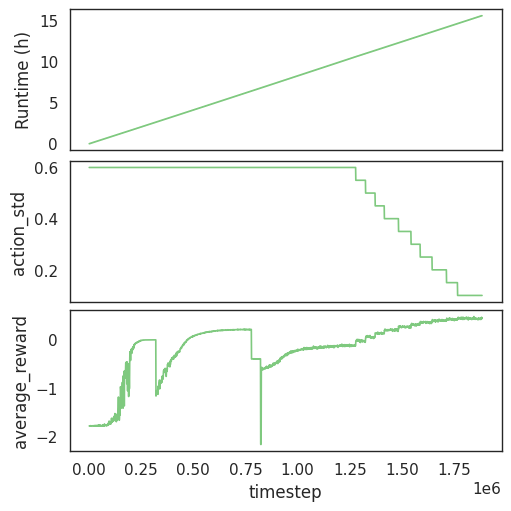

In [7]:
# Load history from wandb
history = run.history(samples=2000)
history['timestep'] = history['end_timestep']
history['Runtime (h)'] = history['_runtime'] / 60**2

# Plot
fig, axs = plt.subplots(3, 1, figsize=(5, 5), sharex=True, layout='constrained')
axs = axs.flatten()
sns.lineplot(history, x='timestep', y='Runtime (h)', ax=axs[0])
sns.lineplot(history, x='timestep', y='action_std', ax=axs[1])
sns.lineplot(history, x='timestep', y='average_reward', ax=axs[2])
plt.show()

### Animate Latent Space

##### Functions

In [8]:
def animate(
    policy,
    env,
    create_func,
    update_func,
    steps=config['train']['max_ep_timesteps'],
    timescale=10,  # Factor speedup
    skip=None,  # Only show frames (frame % skip) == 0
    save_to_file=True,
    fname=config['data']['dataset'],
    file_type='mp4',  # mp4 is faster than gif
    verbose=True,
    **kwargs,
):
    "Generate animation with provided hyperparameters"
    # Default parameters
    if skip is None: skip = 3 if file_type == 'gif' else 1
    assert file_type in ('mp4', 'gif'), f'File type {file_type} not supported.'

    # Calculated parameters
    frames = int(steps / skip) + 1  # +1 for initial state
    interval = int(1e3 * env.delta * skip / timescale)
    fps = int(1e3 / interval)  # fps should be ~30 for gif

    # Create figure and reset environment
    fig, ax, attributes = create_func(env, **kwargs)

    # Formatting
    ax.set_aspect('equal')
    # pos_bound = env.pos_bound
    # ax.set_xlim([-pos_bound-.2, pos_bound+.2])
    # ax.set_ylim([-pos_bound-.2, pos_bound+.2])
    # Update function
    update = lambda frame: update_func(frame, policy=policy, env=env, skip=skip, verbose=verbose, ax=ax, **attributes, **kwargs)

    # CLI
    if verbose: print(f'Total Steps: {steps}')

    # Run animation
    ani = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=interval)
    if save_to_file:
        if file_type == 'mp4': writer = animation.FFMpegWriter(fps=fps, metadata={'artist': 'INEPT'}, extra_args=['-vcodec', 'libx264'], bitrate=8e3)
        elif file_type == 'gif': writer = animation.FFMpegWriter(fps=fps)
        ani.save(os.path.join(PLOT_FOLDER, f'{fname}.{file_type}'), writer=writer, dpi=600)  # Save
    else: display(ani.to_jshtml())  # Display

    # CLI
    if verbose: print()

def env_step(policy, env):
    "Step environment"
    global MAX_BATCH, MAX_NODES
    with torch.no_grad():
            state = env.get_state(include_modalities=True)
            rewards, finished = env.step(policy.act_macro(state, max_batch=MAX_BATCH, max_nodes=MAX_NODES).detach())  # config['train']['max_batch']
    return rewards, finished

def create_integration(
    env,
    transform=None,
    c=None,
    center=False,
    crop=None,
    s=10,
    **kwargs,
):
    "Generic figure creation function"
    fig, ax = plt.subplots(figsize=(6, 6), layout='constrained')

    # Position calculation
    pos = env.pos.detach().cpu()
    if transform is not None: pos = transform(pos)
    pos = pos[:, :2]

    # Styling
    if center: pos = pos - pos.mean(dim=0)  # Center for visualization
    if crop == 'Dynamic':
        ax.set_xlim([pos[:, 0].min() - .2, pos[:, 0].max() + .2])
        ax.set_ylim([pos[:, 1].min() - .2, pos[:, 1].max() + .2])
    elif crop is not None:
        ax.set_xlim([-crop, crop])
        ax.set_ylim([-crop, crop])
    ax.spines[['right', 'top']].set_visible(False)

    # Plot
    sct = ax.scatter(*pos.T, c=[PALETTE[i] for i in c], s=s)

    return fig, ax, dict(sct=sct)

def update_integration(
    frame,
    policy,
    env,
    sct,
    ax,
    transform=None,
    skip=1,
    center=False,
    crop=None,
    verbose=True,
    **kwargs,
):
    "Figure update function for integration"

    # Escape on initial frame
    if frame == 0:
        if verbose: print(f'Processing: {frame*skip}', end='\r')
        ax.set_title(f'Reward: {0: 0.4f}')
        return sct

    # Escape if finished
    if env.finished(): ax.set_title(f'Finished'); return

    # Step environment
    for i in range(skip):
        if verbose: print(f'Processing: {(frame-1)*skip+i+1}', end='\r')
        rewards, finished = env_step(policy, env)
        if finished: break

    # Draw
    pos = env.pos.detach().cpu()
    if transform is not None: pos = transform(pos)
    pos = pos[:, :2]
    if center: pos = pos - pos.mean(dim=0)  # Center for visualization
    if crop == 'Dynamic':
        ax.set_xlim([pos[:, 0].min() - .2, pos[:, 0].max() + .2])
        ax.set_ylim([pos[:, 1].min() - .2, pos[:, 1].max() + .2])
    elif crop is not None:
        ax.set_xlim([-crop, crop])
        ax.set_ylim([-crop, crop])
    sct.set_offsets(pos)
    ax.set_title(f'Reward: {rewards.cpu().mean().item(): 0.4f}')
    return sct

def create_trajectory(*args, **kwargs): return create_integration(*args, **kwargs)

def update_trajectory(
    frame,
    policy,
    env,
    sct,
    ax,
    tracked_node_idx,
    transform=None,
    skip=1,
    center=False,
    arrow_kwargs={},
    crop=None,
    verbose=True,
    **kwargs,
):
    "Figure update function for trajectory"
    # Default arguments
    arrow_kwargs_default = dict(width=.2, color='blue', head_width=0)
    for k, v in arrow_kwargs_default.items():
        if k not in arrow_kwargs: arrow_kwargs[k] = v

    # Escape on initial frame
    if frame == 0:
        if verbose: print(f'Processing: {frame*skip}', end='\r')
        ax.set_title(f'Reward: {0: 0.4f}')
        return sct

    # Escape if finished
    if env.finished(): ax.set_title(f'Finished'); return

    # Save old position
    pos_old = env.pos.detach().cpu()
    if transform is not None: pos_old = transform(pos_old)
    pos_old = pos_old[:, :2]

    # Step environment
    for i in range(skip):
        if verbose: print(f'Processing: {(frame-1)*skip+i+1}', end='\r')
        rewards, finished = env_step(policy, env)
        if finished: break

    # Draw
    pos = env.pos.detach().cpu()
    if transform is not None: pos = transform(pos)
    pos = pos[:, :2]
    if center:
        # Center for visualization
        shift = -pos.mean(dim=0)
        pos += shift; pos_old += shift
    if crop == 'Dynamic':
        ax.set_xlim([pos[:, 0].min() - .2, pos[:, 0].max() + .2])
        ax.set_ylim([pos[:, 1].min() - .2, pos[:, 1].max() + .2])
    elif crop is not None:
        ax.set_xlim([-crop, crop])
        ax.set_ylim([-crop, crop])
    sct.set_offsets(pos)
    ax.set_title(f'Reward: {rewards.cpu().mean().item(): 0.4f}')

    # Draw trajectory arrow
    dpos = pos[tracked_node_idx] - pos_old[tracked_node_idx]
    ax.arrow(*pos_old[tracked_node_idx], *dpos, **arrow_kwargs)

    return sct

##### Setup

In [9]:
# Universal animation parameters
seed = 42
file_type = 'mp4'
integration_steps = 200  # BC: 400
trajectory_steps = 100
perturbation_steps = 100
skip = None
suffix = ''

# Plot parameters
s = 4

# View parameters
transform_type = 'UMAP'  # None, 'UMAP', 'PCA'
transform_dim = 2
center = True
crop = 10  # None, 'Dynamic', Positive Float

# Change labels for BrainChromatin
# ftypes = []
# for t in types[0]:
#     if t.startswith('GluN'): t = 'GluN'
#     if t.startswith('IN'): t = 'IN'
#     ftypes.append(t)
# ftypes = np.array(ftypes)
# types[0] = ftypes

# Process
integration_steps = config['train']['max_ep_timesteps'] if integration_steps is None else min(integration_steps, config['train']['max_ep_timesteps'])
trajectory_steps = config['train']['max_ep_timesteps'] if trajectory_steps is None else min(trajectory_steps, config['train']['max_ep_timesteps'])
perturbation_steps = config['train']['max_ep_timesteps'] if perturbation_steps is None else min(perturbation_steps, config['train']['max_ep_timesteps'])
c_inv, c = np.unique(types[0].flatten(), return_inverse=True)  # TODO: Extend to non-matching modalities

In [10]:
# Filter colors
# selective_colors = {
#     'OPC': (1., 0., 0., 1.),
#     'OliI': (0., 1., 0., 1.),
#     'OliM': (0., 0., 1., 1.),
#     'Ast': (1., 1., 0., 1.),
# }
# PALETTE = [selective_colors[ct] if ct in selective_colors else (.7, .7, .7, .2) for ct in c_inv]
PALETTE = 'husl'
if type(PALETTE) == str:
    PALETTE = [list(sns.color_palette(PALETTE, c.max()+1)[i]) for i, ct in enumerate(c_inv)]
    PALETTE = [[*color, 1. if ct in ('Ast',) else .2] for color, ct in zip(PALETTE, c_inv)]
sns.color_palette(PALETTE)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9701642765060011, 0.4585014668806449, 0.3408973774197841),
 (0.8836443049112893, 0.5240073524369634, 0.19569304285113343),
 (0.7874278248231019, 0.5733291349740255, 0.19484980195522167),
 (0.710130687316902, 0.6046852192663268, 0.19426060163712158),
 (0.6342819788155822, 0.6298701605165659, 0.1937564898893165),
 (0.5432776721247529, 0.6540981095185215, 0.19324494273892204),
 (0.398071759931172, 0.6817894790135043, 0.19262759057177736),
 (0.19592059105779686, 0.6981620017487838, 0.3452219818913641),
 (0.20230615957541276, 0.6892987428727776, 0.5014693473856283),
 (0.2067117296964458, 0.6829103404254792, 0.5829988925822328),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21420912437215422, 0.6714963557258681, 0.6986206664203177),
 (0.21871230574465955, 0.6642950526829915, 0.7592850013140204),
 (0.22537170008202412, 0.6531400148480775, 0.841007805313343),
 (0.30683927374239384, 0.626365255857867, 0.9586535068973675),
 (0.5596943802099308, 0.5764402169887779, 0.9583930713150347),
 (0.7159805974423589, 0.5200441181332478, 0.9581315739457344),
 (0.8578978803740231, 0.44058452715322166, 0.957819659566579),
 (0.9593600685274618, 0.37222734924885714, 0.9023513885514377),
 (0.9628653850704806, 0.4025928454059796, 0.7779310354076443),
 (0.9654130041094379, 0.42308759349350267, 0.6673571095222819)]

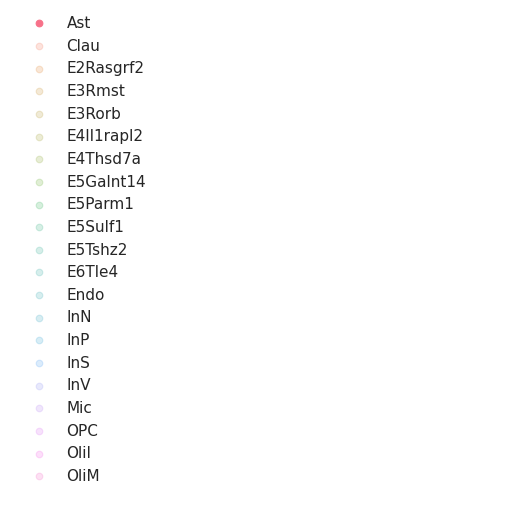

In [11]:
%matplotlib inline

fig, ax = plt.subplots(1, 1)
ax.spines.top.set_visible(False)  # Avoid line through legend if too long
handles = [ax.scatter([], [], color=PALETTE[i]) for i in range(c.max())]
labels = c_inv
legend = plt.legend(handles, labels, loc=3, frameon=False)
ax.axis('off')
fname = f'{config["data"]["dataset"]}{suffix}_legend.pdf'
fig.savefig(os.path.join(PLOT_FOLDER, fname), bbox_inches='tight')

In [12]:
# Fix for old architecture
policy.actor.positional_dim = 2*policy.actor.output_dim
policy.actor.modal_dims = policy.actor.modal_sizes
policy.critic.positional_dim = 2*policy.actor.output_dim
policy.critic.modal_dims = policy.actor.modal_sizes

In [13]:
# Estimate computation time
env.reset()
start = time.perf_counter()
for _ in range(10): env_step(policy, env)
time_per_step = (time.perf_counter() - start) / 10
integration_time = integration_steps * time_per_step
print(f'Estimated integration time: {integration_time:.1f} seconds')
trajectory_time = trajectory_steps * time_per_step
print(f'Estimated trajectory time: {trajectory_time:.1f} seconds')
perturbation_time = perturbation_steps * time_per_step
print(f'Estimated perturbation time: {perturbation_time:.1f} seconds')
cumulative_time = (2 * integration_time + trajectory_time + perturbation_time) / 60
print(f'Cumulative time: {cumulative_time} minutes')
print('*Estimated times do not include overhead from animation.')

Estimated integration time: 1895.8 seconds
Estimated trajectory time: 947.9 seconds
Estimated perturbation time: 947.9 seconds
Cumulative time: 94.79203531006353 minutes
*Estimated times do not include overhead from animation.


##### Steady State

In [14]:
# Reproducibility
torch.manual_seed(seed)

# Get steady-state
env.reset()
print(f'Total Steps: {integration_steps}')
for i in range(integration_steps):
    print(f'Processing: {i+1}', end='\r')
    env_step(policy, env)
print()
pos, vel = env.pos.detach().clone(), env.vel.detach().clone()

Total Steps: 200


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


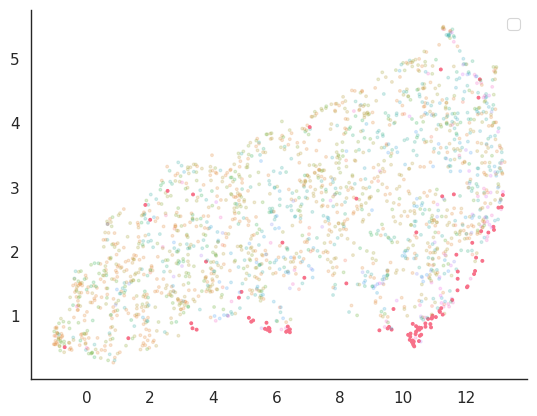

In [15]:
%matplotlib inline

# Make UMAP based on steady-state
if transform_type == 'UMAP':
    import umap
    ss_trans = umap.UMAP(
        n_components=transform_dim,
        # BrainChromatin (n_neighbors=15, min_dist=.1)
        n_neighbors=15,
        min_dist=.1,
        # metric='manhattan',
        n_jobs=1,
        random_state=seed,
    ).fit(pos.cpu())
    transform = lambda x: torch.tensor(ss_trans.transform(x))
elif transform_type == 'PCA':
    import sklearn.decomposition
    ss_trans = sklearn.decomposition.PCA(n_components=transform_dim).fit(pos.cpu())
    transform = lambda x: torch.tensor(ss_trans.transform(x))
else:
    if transform_type is not None: print(f'Transformation type "{transform_type}" unknown, defaulting to `None`')
    transform = None

# Show steady state
fig = plt.figure()
if transform_dim < 3: projection = None
elif transform_dim == 3: projection = '3d'
else: print(f'Unkown dim "{transform_dim}" found, plotting may fail')
ax = fig.add_subplot(111, projection=projection)
transformed_data = pos.cpu()
if transform is not None: transformed_data = transform(transformed_data)
transformed_data = transformed_data[:, :transform_dim].T
ax.scatter(*transformed_data, c=[PALETTE[i] for i in c], s=s)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()
plt.show()

In [16]:
# Center distance
print(f'Centering square distance: {pos.mean(dim=0).square().sum().cpu().item():.3f}')

# Silhouette score
silhouette_score = sklearn.metrics.silhouette_score(pos.cpu(), types[0])
print(f'Silhouette Score: {silhouette_score:.3f}')

Centering square distance: 1.323
Silhouette Score: -0.282


##### Integration

In [17]:
# %matplotlib agg

# # Reproducibility
# torch.manual_seed(seed)

# # Integration animation
# env.reset()
# animate(
#     policy,
#     env,
#     transform=transform,
#     steps=integration_steps,
#     skip=skip,
#     create_func=create_integration,
#     update_func=update_integration,
#     c=c,
#     s=s,
#     center=center,
#     crop=crop,
#     fname=f'{config["data"]["dataset"]}{suffix}',
#     file_type=file_type)

##### Trajectory

In [18]:
# # BrainChromatin
# rg_cell = np.argwhere(types[0] == 'RG')[0][0]
# nipc_cell = np.argwhere(types[0] == 'nIPC')[0][0]
# in_cell = np.argwhere(types[0] == 'IN1')[0][0]

# # Parameters
# node_to_analyze, node_to_copy = in_cell, rg_cell  # Which node will be analyzed

In [19]:
# %matplotlib agg

# # Reproducibility
# torch.manual_seed(seed)

# # Trajectory analysis
# env.pos, env.vel = pos.detach().clone(), vel.detach().clone()  # Reset env to steady state
# if node_to_copy is None: env.pos[node_to_analyze] = env.pos_bound * 2 * (torch.rand(2) - .5)  # Randomize node position
# else: env.pos[node_to_analyze] = env.pos[node_to_copy]  # Copy node position
# animate(
#     policy,
#     env,
#     transform=transform,
#     steps=trajectory_steps,
#     skip=skip,
#     create_func=create_trajectory,
#     update_func=update_trajectory,
#     c=c,
#     s=s,
#     tracked_node_idx=node_to_analyze,
#     center=center,
#     crop=crop,
#     fname=f'{config["data"]["dataset"]}{suffix}_trajectory',
#     file_type=file_type)

##### Feature Perturbation

In [20]:
%matplotlib agg

for modality in range(len(modalities)):
    # Get random parameters
    features_to_randomize = [(modality, list(range(modalities[modality].shape[1])))]  # (modality, [features])

    # Reproducibility
    torch.manual_seed(seed)

    # Feature modification
    env.pos, env.vel = pos.detach().clone(), vel.detach().clone()  # Reset env to steady state
    old_modalities = [m.detach().clone() for m in env.modalities]
    for modality, features_list in features_to_randomize:
        for feature in features_list:
            env.modalities[modality][:, feature] = torch.normal(
                env.modalities[modality][:, feature].mean().expand(env.modalities[modality].shape[0]),
                env.modalities[modality][:, feature].std().expand(env.modalities[modality].shape[0]),
    )
    animate(
        policy,
        env,
        transform=transform,
        steps=perturbation_steps,
        skip=skip,
        create_func=create_integration,
        update_func=update_integration,
        c=c,
        s=s,
        center=center,
        crop=crop,
        fname=f'{config["data"]["dataset"]}{suffix}_feature-{modality}',
        file_type=file_type)
    env.modalities = old_modalities

Total Steps: 100



Total Steps: 100
